In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import utils
from prophet import Prophet

### Carregando o dataframe e preparando para trabalhar com o Prophet:

In [22]:
df = pd.read_csv('./Ibovespa.csv')
df = df[['Data', 'Último']]
df.rename(columns={'Data':'ds','Último':'y'},inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format='%d.%m.%Y')
df.head()

,ds,y
0,2024-01-09,131.447
1,2024-01-08,132.427
2,2024-01-05,132.023
3,2024-01-04,131.226
4,2024-01-03,132.834


In [34]:
# pegando somente os dados > 31/12/2020
df = df[df['ds'] > '2020-12-31']

## Seprando os dados em treino e teste

In [35]:
train_data = df.sample(frac=0.8, random_state=0)
test_data = df.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (601, 2)
testing data size : (150, 2)


In [36]:
train_data.sort_values(by='ds', inplace=True)
test_data.sort_values(by='ds', inplace=True)

In [37]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 601 entries, 750 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      601 non-null    datetime64[ns]
 1   y       601 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.1 KB


In [38]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=20, freq='M')
previsao = modelo.predict(dataFramefuture)
previsao.head()

12:47:23 - cmdstanpy - INFO - Chain [1] start processing
12:47:23 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-04,117.921367,113.386934,119.875482,117.921367,117.921367,-1.181938,-1.181938,-1.181938,2.148704,...,0.020413,0.020413,0.020413,-3.351055,-3.351055,-3.351055,0.0,0.0,0.0,116.739429
1,2021-01-05,117.872266,113.320046,120.354191,117.872266,117.872266,-1.157316,-1.157316,-1.157316,2.148704,...,-0.091965,-0.091965,-0.091965,-3.214055,-3.214055,-3.214055,0.0,0.0,0.0,116.714950
2,2021-01-06,117.823165,113.645537,120.409507,117.823165,117.823165,-0.762290,-0.762290,-0.762290,2.148704,...,0.156359,0.156359,0.156359,-3.067353,-3.067353,-3.067353,0.0,0.0,0.0,117.060875
3,2021-01-07,117.774064,114.096693,120.659489,117.774064,117.774064,-0.386303,-0.386303,-0.386303,2.148704,...,0.375864,0.375864,0.375864,-2.910871,-2.910871,-2.910871,0.0,0.0,0.0,117.387761
4,2021-01-08,117.724963,113.954599,120.503757,117.724963,117.724963,-0.519500,-0.519500,-0.519500,2.148704,...,0.076503,0.076503,0.076503,-2.744707,-2.744707,-2.744707,0.0,0.0,0.0,117.205463


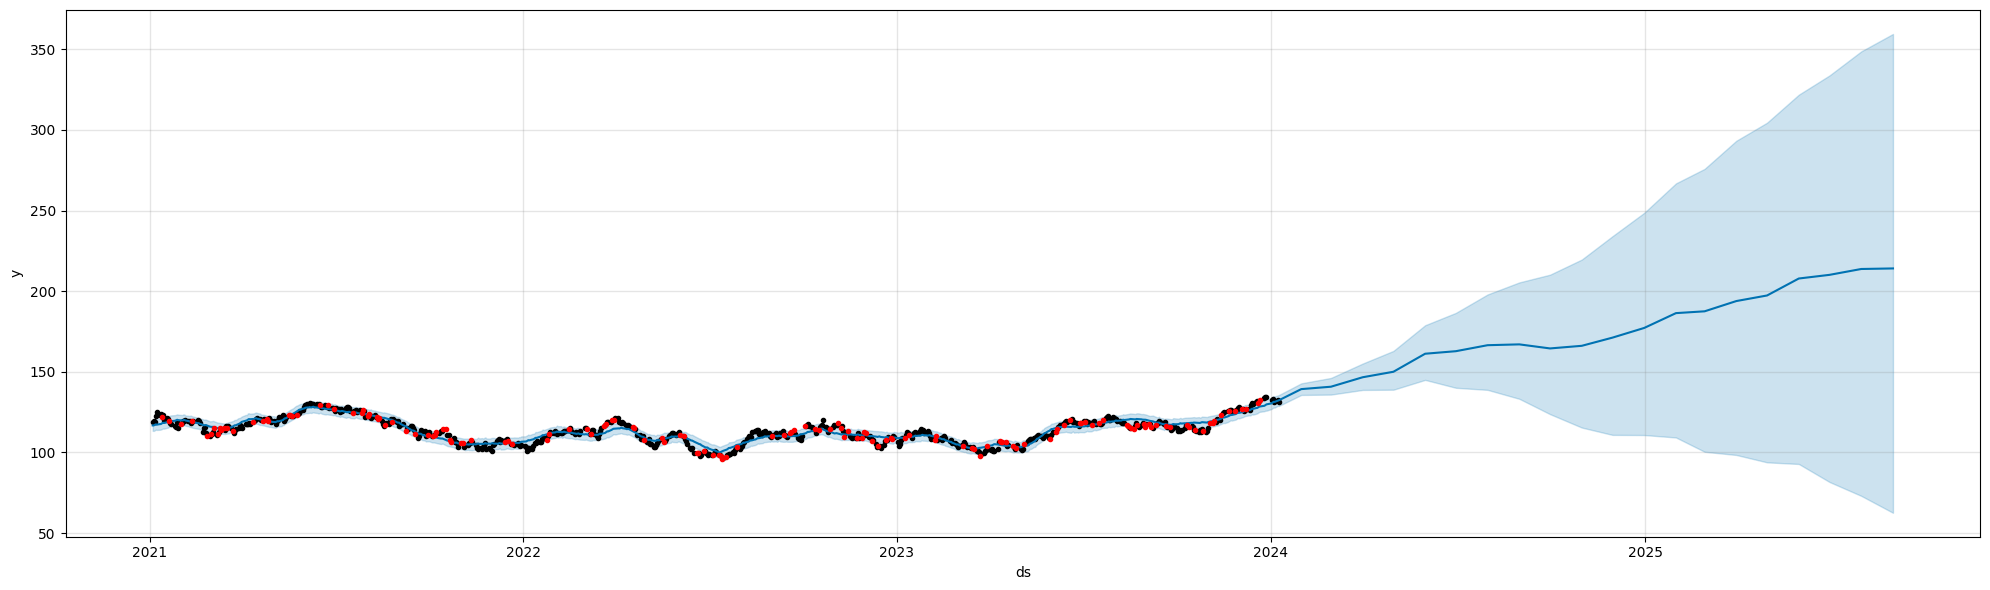

In [39]:
modelo.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

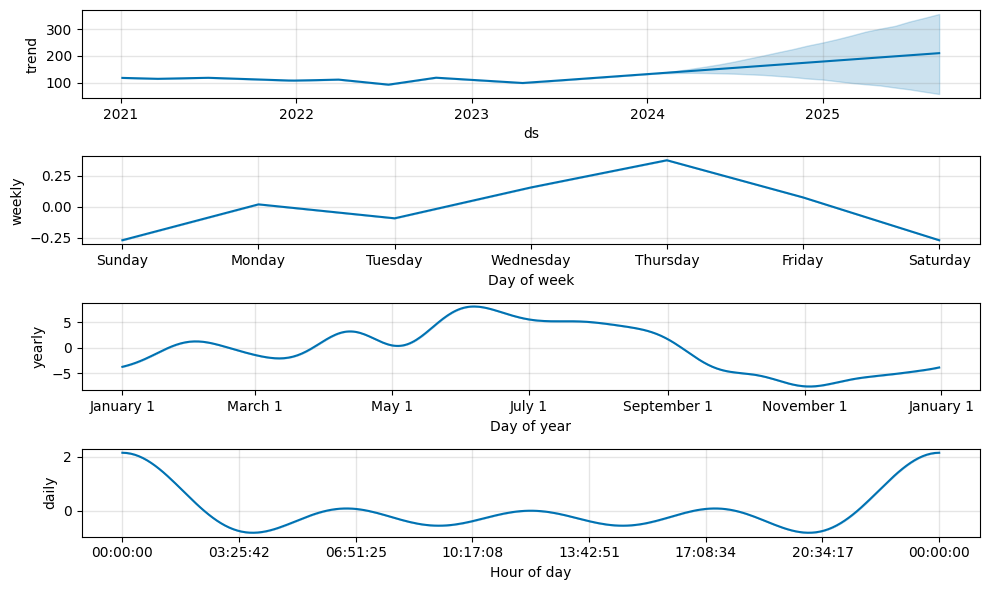

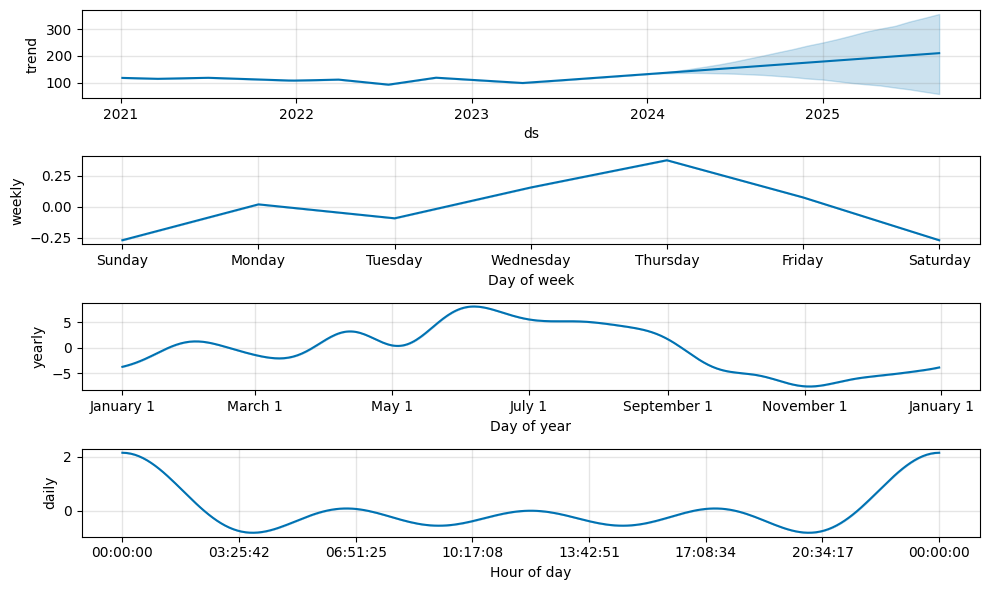

In [40]:
modelo.plot_components(previsao, figsize=(10,6))

In [41]:
# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 1.90%


In [42]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(modelo, initial='730 days', period='180 days', horizon = '365 days')

  0%|          | 0/1 [00:00<?, ?it/s]12:47:50 - cmdstanpy - INFO - Chain [1] start processing
12:47:50 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


In [44]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-01-10,107.417371,104.710580,110.232525,110.817,2023-01-09
1,2023-01-11,107.759317,105.104444,110.621838,112.517,2023-01-09
2,2023-01-12,108.104298,105.435901,110.930479,111.850,2023-01-09
3,2023-01-16,108.193862,105.626669,110.780601,109.213,2023-01-09
4,2023-01-17,108.186836,105.386865,110.872066,111.439,2023-01-09


In [45]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,28 days,9.937234,3.152338,2.945550,0.026317,0.030678,0.026601,0.421053
1,31 days,10.572325,3.251511,3.022436,0.027071,0.030715,0.027278,0.421053
2,32 days,10.478767,3.237092,3.012403,0.027070,0.030715,0.027182,0.421053
3,35 days,10.449390,3.232552,3.008442,0.027082,0.030715,0.027135,0.473684
4,36 days,11.436115,3.381733,3.188918,0.028762,0.031779,0.028769,0.421053
...,...,...,...,...,...,...,...,...
173,359 days,72.596415,8.520353,7.614218,0.059346,0.054843,0.057202,1.000000
174,360 days,65.818185,8.112841,7.237474,0.056273,0.052695,0.054334,1.000000
175,361 days,59.696278,7.726337,6.856107,0.053213,0.044006,0.051456,1.000000
176,364 days,54.758673,7.399910,6.517633,0.050519,0.041278,0.048907,1.000000
